In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.feature as feature
import ipywidgets

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from tqdm import tqdm

# Загрузка данных

Лекция - https://yadi.sk/i/sFfaM-zbfV7cEw

В рамках данного семинара предлагается поработать с набором данных Describable Textures Dataset (DTD) - https://www.robots.ox.ac.uk/~vgg/data/dtd/. Основным заданием будет решить задачу классификации текстур на основе текстурных признаков основанных на полутоновой матрице смежности (GLCM, Grey-Level Co-occurence Matrix).

In [27]:
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

--2022-04-21 12:50:22--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/x-gzip]
Saving to: ‘dtd-r1.0.1.tar.gz.1’

dtd-r1.0.1.tar.gz.1 100%[===================>] 596.27M  19.8MB/s    in 31s     

2022-04-21 12:50:54 (19.5 MB/s) - ‘dtd-r1.0.1.tar.gz.1’ saved [625239812/625239812]



In [28]:
!tar -xvf dtd-r1.0.1.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
dtd/images/porous/porous_0122.jpg
dtd/images/porous/porous_0156.jpg
dtd/images/porous/porous_0091.jpg
dtd/images/porous/porous_0083.jpg
dtd/images/porous/porous_0124.jpg
dtd/images/porous/porous_0151.jpg
dtd/images/porous/porous_0131.jpg
dtd/images/porous/porous_0096.jpg
dtd/images/porous/porous_0153.jpg
dtd/images/porous/porous_0154.jpg
dtd/images/porous/porous_0052.jpg
dtd/images/porous/porous_0172.jpg
dtd/images/porous/porous_0044.jpg
dtd/images/porous/porous_0118.jpg
dtd/images/porous/porous_0140.jpg
dtd/images/porous/porous_0152.jpg
dtd/images/porous/porous_0171.jpg
dtd/images/porous/porous_0132.jpg
dtd/images/porous/porous_0105.jpg
dtd/images/porous/porous_0127.jpg
dtd/images/porous/porous_0130.jpg
dtd/images/porous/porous_0104.jpg
dtd/images/porous/porous_0066.jpg
dtd/images/porous/porous_0158.jpg
dtd/images/porous/porous_0128.jpg
dtd/images/porous/porous_0138.jpg
dtd/images/porous/porous_0133.jpg
dtd/images/por

In [ ]:
img = cv2.imread('dtd/images/lined/lined_0039.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

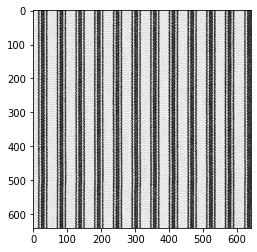

In [ ]:
plt.imshow(img_gray, cmap='Greys_r')

# GLCM

Реализацию расчета GLCM и некоторых признаков можно взять из библиотеки skimage:

In [ ]:
import skimage.feature as feature

In [ ]:
@ipywidgets.interact(
    distance=ipywidgets.IntSlider(min=1, max=100, step=1, value=1),
    angle=ipywidgets.IntSlider(min=-180, max=180, step=1, value=0)
)
def play_with_glcm(distance, angle):
    glcm = feature.greycomatrix(img_gray, [distance], [angle * np.pi / 180], levels=256)
    plt.imshow(glcm[:, :, 0, 0], cmap='coolwarm')

interactive(children=(IntSlider(value=1, description='distance', min=1), IntSlider(value=0, description='angle…

## Вопрос 1

Как по полутоновой матрице смежности определить период текстуры? Чему примерно он равен на рисунке выше (вдоль оси X)?

**Ответ:** f(x,y) – полутоновая функция яркости изображения
размером N×M пикселей, dx и dy – параметры сдвига,
задающие взаимное расположение пикселей соответственно
по вертикальной и горизонтальной оси

In [48]:
glcm = feature.greycomatrix(img_gray, [50], [0], levels=256)

contrast = feature.greycoprops(glcm, 'contrast')
dissimilarity = feature.greycoprops(glcm, 'dissimilarity')
homogeneity = feature.greycoprops(glcm, 'homogeneity')
energy = feature.greycoprops(glcm, 'energy')
correlation = feature.greycoprops(glcm, 'correlation')
ASM = feature.greycoprops(glcm, 'ASM')

print("Contrast: {}".format(contrast))
print("Dissimilarity: {}".format(dissimilarity))
print("Homogeneity: {}".format(homogeneity))
print("Energy: {}".format(energy))
print("Correlation: {}".format(correlation))
print("ASM: {}".format(ASM))

Contrast: [[8769.00970869]]
Dissimilarity: [[69.9390625]]
Homogeneity: [[0.02388795]]
Energy: [[0.00680149]]
Correlation: [[0.15372043]]
ASM: [[4.6260251e-05]]


# Классификация текстур

Сначала определим функцию для загрузки датасета, которая для каждого изображения сразу расчитает его набор признаков:

In [ ]:
def load_dtd(path, get_features_fn):
    classes = sorted(os.listdir(os.path.join(path, 'images')))

    rows = []
    name2idx = {}

    for class_name in tqdm(classes):
        folder_path = os.path.join(path, 'images', class_name)
        for img_name in os.listdir(folder_path):
            if not img_name.endswith('.jpg'):
                continue

            img_path = os.path.join(folder_path, img_name)

            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            features = get_features_fn(img_gray)

            features['class'] = class_name

            name2idx[img_name] = len(rows)
            rows.append(features)
    
    splits = []

    for split in range(1, 11):
        train_filepath = os.path.join(path, 'labels', 'train{}.txt'.format(split))
        val_filepath = os.path.join(path, 'labels', 'val{}.txt'.format(split))
        test_filepath = os.path.join(path, 'labels', 'test{}.txt'.format(split))

        with open(train_filepath) as f:
            train_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        with open(val_filepath) as f:
            val_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        with open(test_filepath) as f:
            test_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        splits.append((train_ids, val_ids))

    return pd.DataFrame(rows), splits

В качестве примера определим функцию, возвражающую доступные в skimage текстурные характеристики:

In [ ]:
def get_features(img_gray):
    dists = [1]
    angles = [np.pi/2]

    props = ['contrast', 'dissimilarity', 'homogeneity', 
             'energy', 'correlation', 'ASM']

    graycom = feature.greycomatrix(img_gray, dists, angles, levels=256)

    features = {}
    for prop in props:
        prop_values = feature.greycoprops(graycom, prop)
        for i, dist in enumerate(dists):
            for j, angle in enumerate(angles):
                features[prop + '_{:.3f}_{:.3f}'.format(dist, angle)] = prop_values[i, j]
    
    return features

In [ ]:
df, splits = load_dtd('dtd', get_features)

100%|██████████| 47/47 [01:07<00:00,  1.44s/it]


In [ ]:
df.head()

,contrast_1.000_1.571,dissimilarity_1.000_1.571,homogeneity_1.000_1.571,energy_1.000_1.571,correlation_1.000_1.571,ASM_1.000_1.571,class
0,513.782309,13.812570,0.153373,0.017838,0.937647,0.000318,banded
1,0.000000,0.000000,1.000000,0.298442,1.000000,0.089067,banded
2,0.391564,0.132244,0.952901,0.239216,0.999755,0.057224,banded
3,1.172957,0.445250,0.828478,0.397159,0.999825,0.157736,banded
4,710.970823,17.322357,0.123129,0.023466,0.846160,0.000551,banded


In [ ]:
df.shape

(5640, 7)

In [ ]:
X = df.iloc[:, :-1]
y = df['class']

В качестве модели попробуем случайный лес:

In [ ]:
classifier = RandomForestClassifier(100, max_depth=6)

In [ ]:
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=splits, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.1s finished


In [ ]:
scores.mean()

0.10835106382978724

## Задание 1

Улучшите модель классификации, добавив дополнительные признаки (в том числе из тех, что рассматриваются в лекции), изменив модель. Целевые показатели метрики accuracy > 0.5.

Классификация текстур ДОП
Сначала определим функцию для загрузки датасета, которая для каждого изображения сразу расчитает его набор признаков:

In [49]:
glcm = feature.greycomatrix(img_gray, [50], [0], levels=256, symmetric=True, normed=True)

contrast = feature.greycoprops(glcm, 'contrast')
dissimilarity = feature.greycoprops(glcm, 'dissimilarity')
homogeneity = feature.greycoprops(glcm, 'homogeneity')
energy = feature.greycoprops(glcm, 'energy')
correlation = feature.greycoprops(glcm, 'correlation')
ASM = feature.greycoprops(glcm, 'ASM')


print("Contrast: {}".format(contrast))
print("Dissimilarity: {}".format(dissimilarity))
print("Homogeneity: {}".format(homogeneity))
print("Energy: {}".format(energy))
print("Correlation: {}".format(correlation))
print("ASM: {}".format(ASM))


Contrast: [[8769.00970869]]
Dissimilarity: [[69.9390625]]
Homogeneity: [[0.02388795]]
Energy: [[0.00680149]]
Correlation: [[0.15372043]]
ASM: [[4.6260251e-05]]


In [ ]:
def load_dtd(path, get_features_fn):
    classes = sorted(os.listdir(os.path.join(path, 'images')))

    rows = []
    name2idx = {}

    for class_name in tqdm(classes):
        folder_path = os.path.join(path, 'images', class_name)
        for img_name in os.listdir(folder_path):
            if not img_name.endswith('.jpg'):
                continue

            img_path = os.path.join(folder_path, img_name)

            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            features = get_features_fn(img_gray)

            features['class'] = class_name

            name2idx[img_name] = len(rows)
            rows.append(features)
    
    splits = []

    for split in range(1, 11):
        train_filepath = os.path.join(path, 'labels', 'train{}.txt'.format(split))
        val_filepath = os.path.join(path, 'labels', 'val{}.txt'.format(split))
        test_filepath = os.path.join(path, 'labels', 'test{}.txt'.format(split))

        with open(train_filepath) as f:
            train_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        with open(val_filepath) as f:
            val_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        with open(test_filepath) as f:
            test_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        splits.append((train_ids, val_ids))

    return pd.DataFrame(rows), splits

В качестве примера определим функцию, возвражающую доступные в skimage текстурные характеристики:



Из лекции

Контраст:
Инерция:
Энтропия:
Однородность:
Корреляция:
Автокорреляция:
Тень:
Максимальная
вероятность:
Обратный

In [44]:
def get_features(img_gray):
    dists = [1]
    angles = [np.pi/2]

    props = ['contrast', 'dissimilarity', 'homogeneity', 
             'energy', 'correlation', 'ASM', 'idMoment']
    #levels = 256
    #symmetric = True
    #normed = True

    graycom = feature.greycomatrix(img_gray, dists, angles, levels=256 ,symmetric=False)

    features = {}
    for prop in props:
        prop_values = feature.greycoprops(graycom, prop)
        for i, dist in enumerate(dists):
            for j, angle in enumerate(angles):
                features[prop + '_{:.3f}_{:.3f}'.format(dist, angle)] = prop_values[i, j]
    
    return features

In [45]:
df, splits = load_dtd('dtd', get_features)

  0%|          | 0/47 [00:00<?, ?it/s]


ValueError: ignored

In [43]:
X = df.iloc[:, :-1]
y = df['class']

В качестве модели выбрала - svm

In [ ]:
from sklearn import svm

In [35]:
classifier = svm.SVC(kernel='rbf')

In [36]:
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=splits, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.5s finished


In [ ]:
scores.mean() #true

0.039361702127659576

In [37]:
scores.mean() #false

0.039361702127659576

Рэндом форест


In [38]:
classifier = RandomForestClassifier(100, max_depth=6)

In [39]:
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=splits, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


In [31]:
scores.mean() #true

0.10617021276595744

In [40]:
scores.mean() #false

0.10680851063829788